In [1]:
import os
import pandas as pd
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import time
import copy
from sklearn.model_selection import train_test_split

# Directory setup
base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/"
normal_images_dir = os.path.join(base_dir, "NORMAL")
pneumonia_images_dir = os.path.join(base_dir, "PNEUMONIA")

# Collecting images
normal_images = [os.path.join(normal_images_dir, x) for x in os.listdir(normal_images_dir) if x.endswith('.jpeg')]
pneumonia_images = [os.path.join(pneumonia_images_dir, x) for x in os.listdir(pneumonia_images_dir) if x.endswith('.jpeg')]

# Labels
labels = ['normal'] * len(normal_images) + ['pneumonia'] * len(pneumonia_images)

# Combine datasets
image_paths = normal_images + pneumonia_images

# Splitting the dataset into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Image transformations
transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])  # Normalize for grayscale images
])

# Custom Dataset Class
class XRayDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = 1 if self.labels[idx] == 'pneumonia' else 0
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image, label

# DataLoaders

train_dataset = XRayDataset(train_paths, train_labels, transform)
val_dataset = XRayDataset(val_paths, val_labels, transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def visualize_images(real_images, transformed_images, epoch, save_dir):
    real_images = real_images.detach().cpu()
    transformed_images = transformed_images.detach().cpu()
    
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 4))
    for i in range(8):
        axes[0, i].imshow(real_images[i].squeeze(0), cmap='gray')
        axes[1, i].imshow(transformed_images[i].squeeze(0), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].axis('off')

    plt.savefig(os.path.join(save_dir, f'epoch_{epoch+1}.png'))
    plt.show()
    plt.close(fig)

In [3]:
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Initialize the model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjust for 1-channel input
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming binary classification: normal vs pneumonia
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 41.3MB/s]


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import copy
import torchvision

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, dataloaders=None, save_path="/kaggle/working/best_resnet18_model.pth"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # training mode
            else:
                model.eval()   # evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights and save to the specified path
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), save_path)
    return model

# Set up dataloaders, model, optimizer, etc. as needed before calling this function
# Example of using the training function
model_ft = train_model(model, criterion, optimizer, scheduler, num_epochs=25, dataloaders=dataloaders, save_path="/kaggle/working/best_resnet18_model.pth")

Epoch 1/25
----------
train Loss: 0.0125 Acc: 0.9966
val Loss: 0.0311 Acc: 0.9856
Epoch 2/25
----------
train Loss: 0.0090 Acc: 0.9983
val Loss: 0.0320 Acc: 0.9895
Epoch 3/25
----------
train Loss: 0.0098 Acc: 0.9978
val Loss: 0.0307 Acc: 0.9895
Epoch 4/25
----------
train Loss: 0.0108 Acc: 0.9981
val Loss: 0.0339 Acc: 0.9866
Epoch 5/25
----------
train Loss: 0.0107 Acc: 0.9974
val Loss: 0.0346 Acc: 0.9856
Epoch 6/25
----------
train Loss: 0.0115 Acc: 0.9976
val Loss: 0.0318 Acc: 0.9885
Epoch 7/25
----------
train Loss: 0.0106 Acc: 0.9986
val Loss: 0.0335 Acc: 0.9885
Epoch 8/25
----------
train Loss: 0.0111 Acc: 0.9971
val Loss: 0.0334 Acc: 0.9895
Epoch 9/25
----------
train Loss: 0.0101 Acc: 0.9978
val Loss: 0.0338 Acc: 0.9875
Epoch 10/25
----------
train Loss: 0.0102 Acc: 0.9978
val Loss: 0.0339 Acc: 0.9875
Epoch 11/25
----------
train Loss: 0.0083 Acc: 0.9988
val Loss: 0.0339 Acc: 0.9875
Epoch 12/25
----------
train Loss: 0.0106 Acc: 0.9978
val Loss: 0.0382 Acc: 0.9828
Epoch 13/25
-

In [4]:
import torch
import torch.nn as nn

def conv3x3(in_planes, out_planes, stride=1):
    
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.downsample = nn.Sequential(
            # input: 1 x 256 x 256
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), # output: 64 x 128 x 128
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # output: 128 x 64 x 64
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # output: 256 x 32 x 32
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), # output: 512 x 16 x 16
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'), # output: 512 x 32 x 32
            conv3x3(512, 256), 
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='nearest'), # output: 256 x 64 x 64
            conv3x3(256, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='nearest'), # output: 128 x 128 x 128
            conv3x3(128, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='nearest'), # output: 64 x 256 x 256
            conv3x3(64, 1),
            nn.Tanh()  # Final output: 1 x 256 x 256
        )

    def forward(self, x):
        x = self.downsample(x)
        x = self.upsample(x)
        return x

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 1 x 256 x 256
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # Output: 128 x 128
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: 64 x 64
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: 32 x 32
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # Output: 16 x 16
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),  # Output: 8 x 8
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 2048, kernel_size=4, stride=2, padding=1),  # Output: 4 x 4
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(2048, 1, kernel_size=3, stride=1, padding=0),  # Output: 1 x 1
            nn.AdaptiveAvgPool2d(1),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1)  # Flatten the output to ensure it is [batch_size]

In [6]:
import os
import pandas as pd
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image

# Directory setup
base_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/"
normal_images_dir = os.path.join(base_dir, "NORMAL")
pneumonia_images_dir = os.path.join(base_dir, "PNEUMONIA")

# Collecting images
normal_images = [os.path.join(normal_images_dir, x) for x in os.listdir(normal_images_dir) if x.endswith('.jpeg')][:500]
pneumonia_images = [os.path.join(pneumonia_images_dir, x) for x in os.listdir(pneumonia_images_dir) if x.endswith('.jpeg')][:500]

# Image transformations
transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])  # Normalize for grayscale images
])

# Custom Dataset Class for Generator (Pneumonia Images)
class PneumoniaDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image

# Custom Dataset Class for Discriminator (Normal Images)
class NormalDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")  # Convert to grayscale
        if self.transform:
            image = self.transform(image)
        return image

# DataLoaders
pneumonia_dataset = PneumoniaDataset(pneumonia_images, transform=transform)
normal_dataset = NormalDataset(normal_images, transform=transform)

pneumonia_loader = DataLoader(pneumonia_dataset, batch_size=32, shuffle=True)
normal_loader = DataLoader(normal_dataset, batch_size=32, shuffle=True)

# Length of DataLoader and example access
print("Pneumonia DataLoader batches:", len(pneumonia_loader))
print("Normal DataLoader batches:", len(normal_loader))

for images in pneumonia_loader:
    print(images.shape)  # Expecting [batch_size, 1, 256, 256]
    break

for images in normal_loader:
    print(images.shape)  # Expecting [batch_size, 1, 256, 256]
    break

Pneumonia DataLoader batches: 16
Normal DataLoader batches: 16
torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])


In [7]:
import torch
import matplotlib.pyplot as plt
def visualize_images(real_images, transformed_images):
    real_images = real_images.detach().cpu()
    transformed_images = transformed_images.detach().cpu()
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 4))
    for i in range(8):
        axes[0, i].imshow(real_images[i].squeeze(0), cmap='gray')
        axes[1, i].imshow(transformed_images[i].squeeze(0), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].axis('off')

    plt.show()
    plt.close(fig)

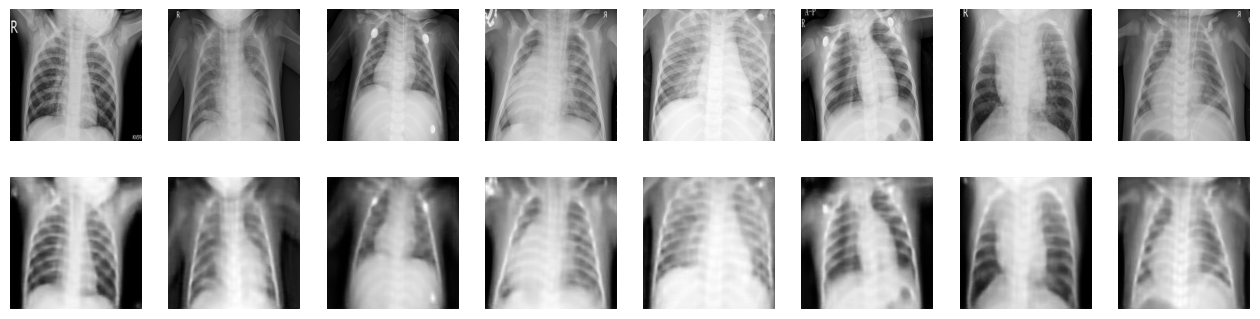

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia']


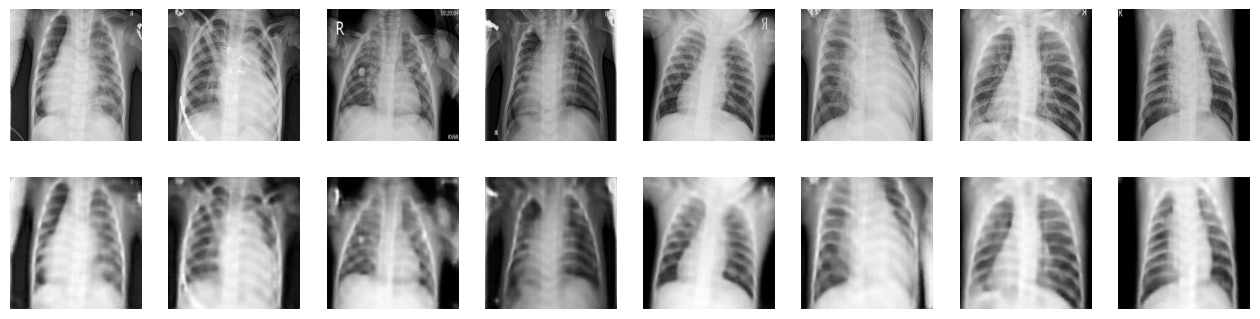

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia']


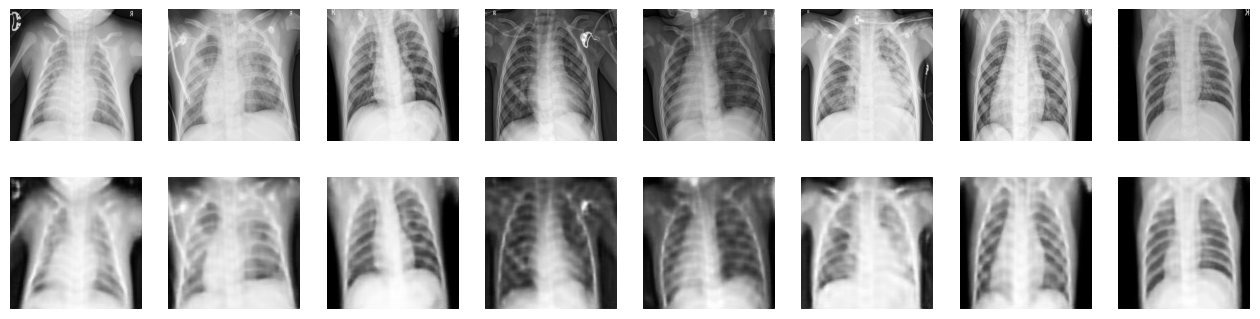

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia']


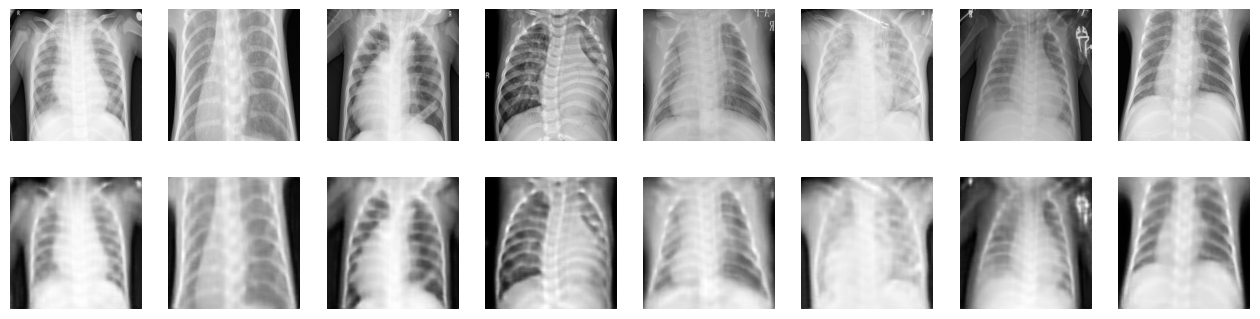

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia']


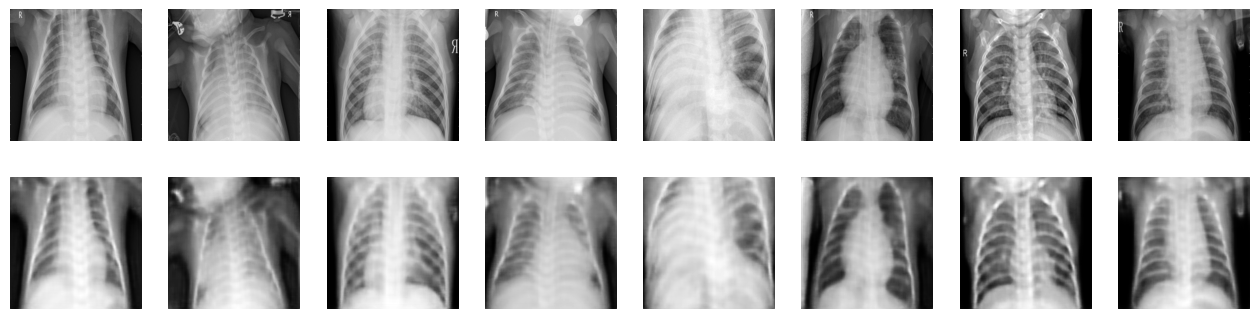

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia']


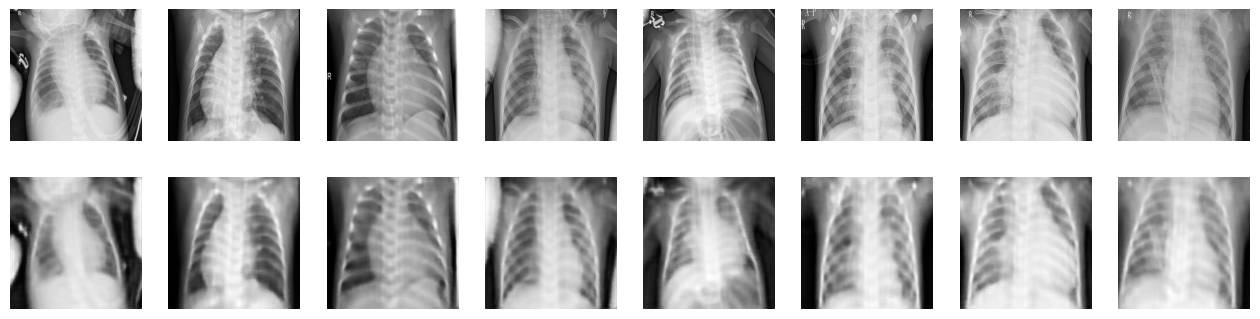

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia']


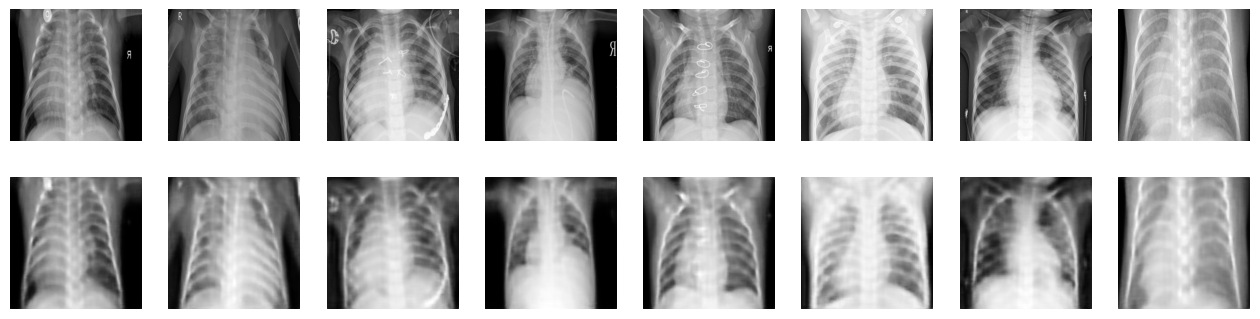

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia']


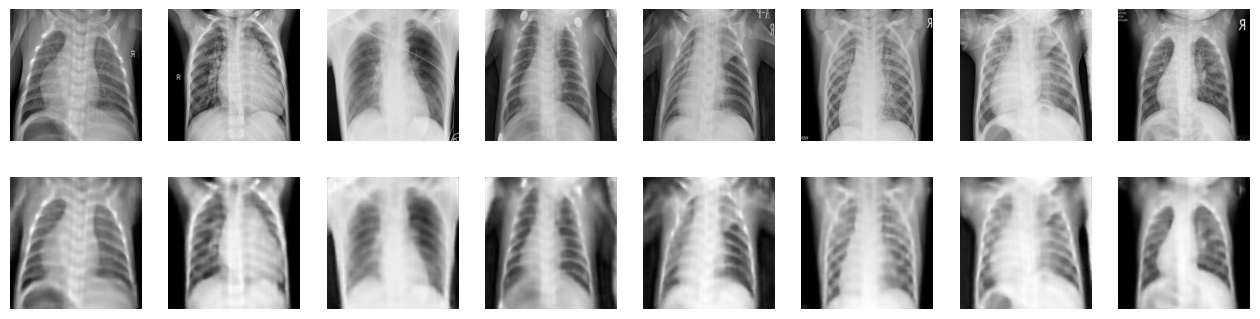

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia']


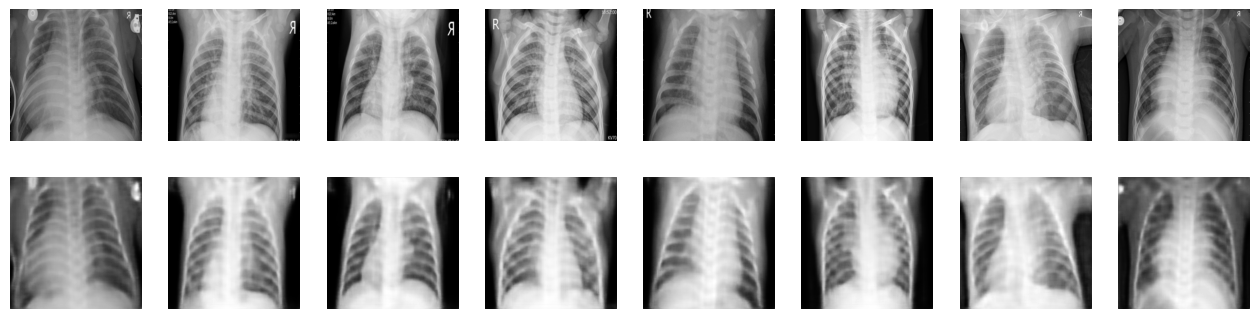

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia']


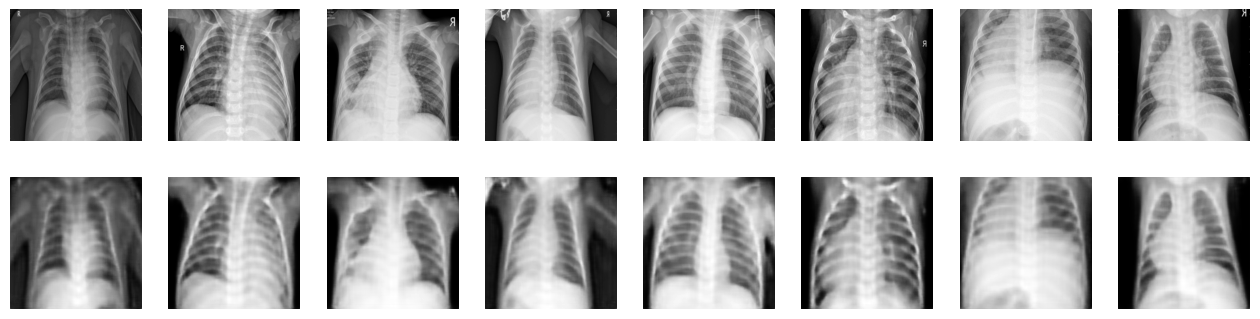

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia']


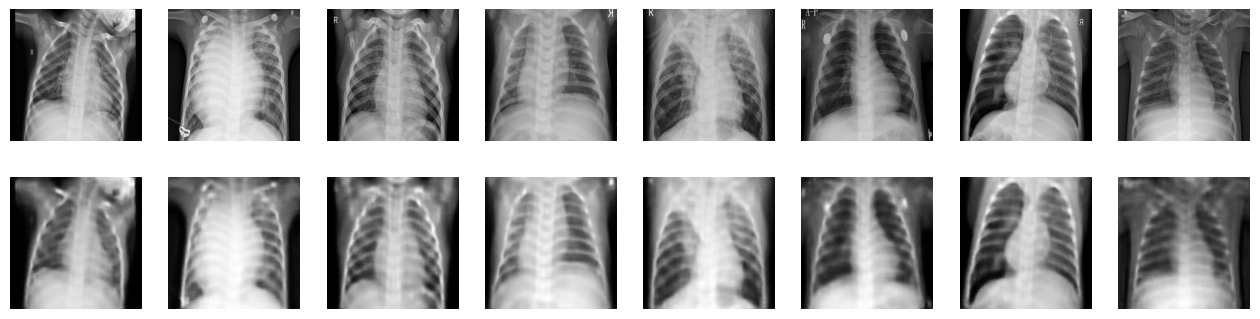

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia']


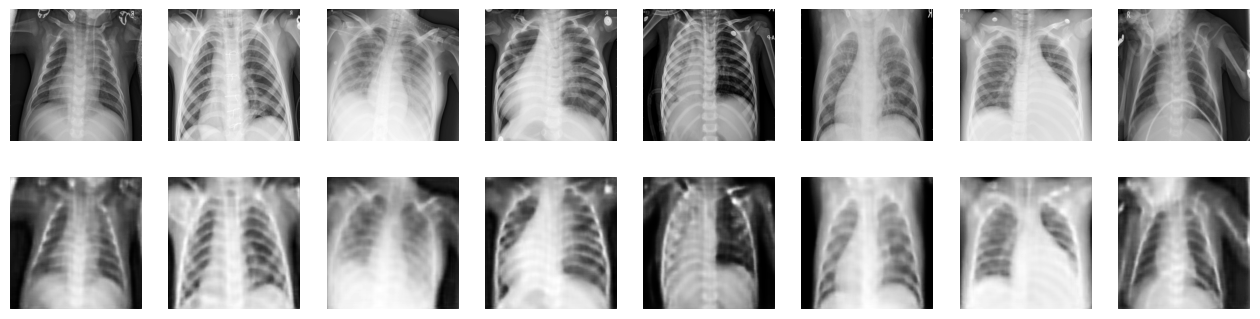

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia']


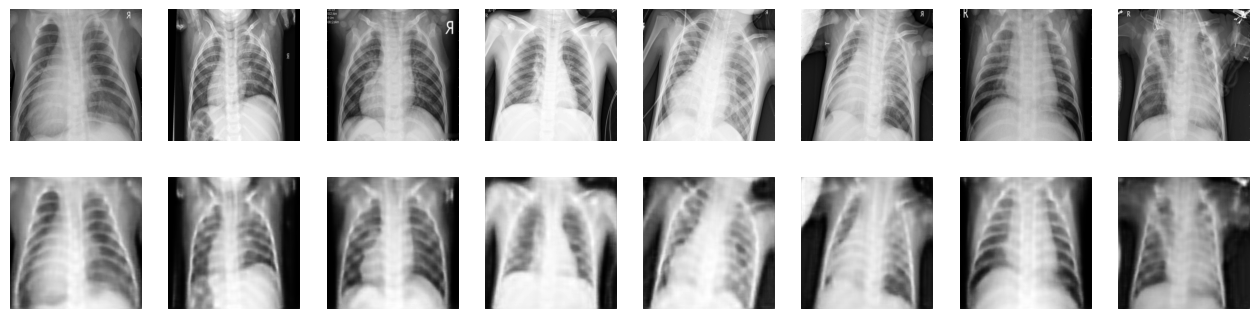

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia']


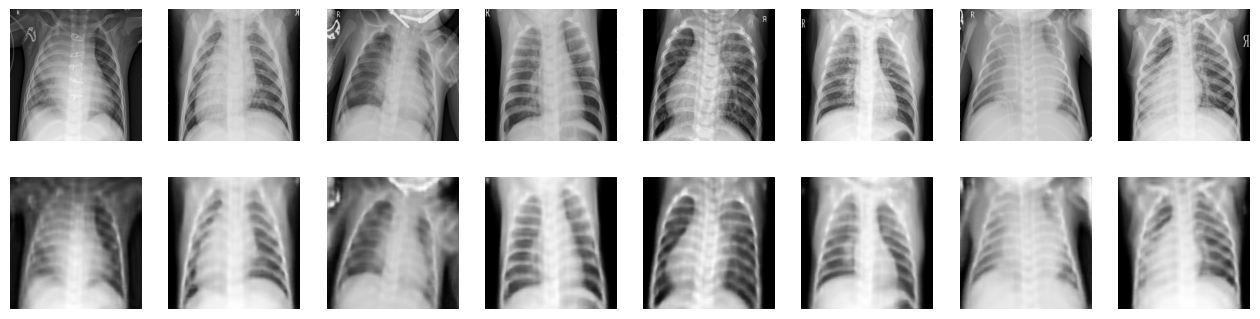

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia']


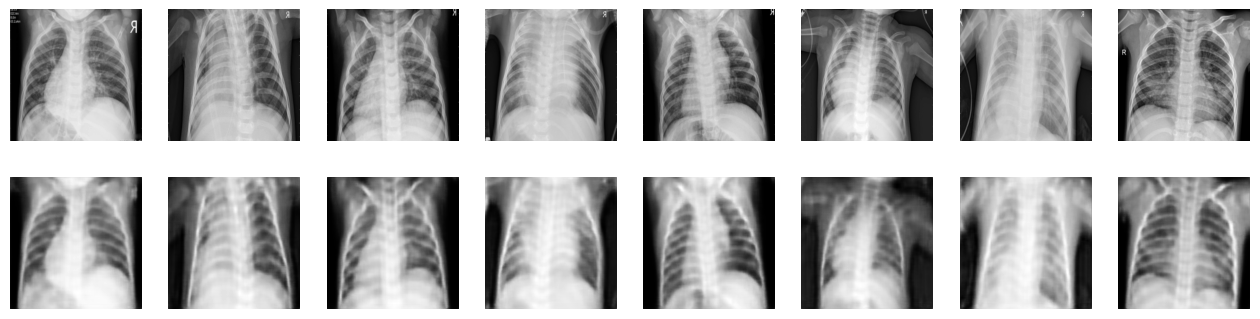

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia']


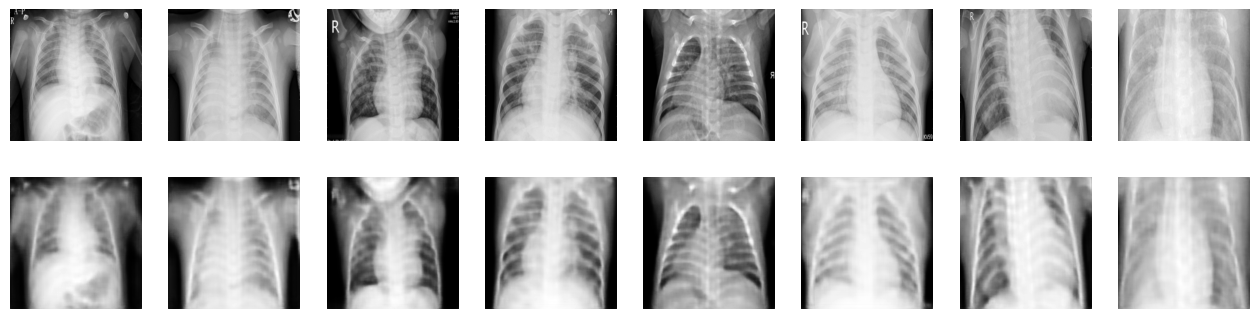

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia']


In [8]:
import torch
import torchvision
from torchvision import models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model(model_path, model):
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    return model

#classifier_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator().to(device)
discriminator = Discriminator().to(device)
classifier_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
classifier_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Adjust for 1-channel input
classifier_model_num_ftrs = classifier_model.fc.in_features
classifier_model.fc = nn.Linear(classifier_model_num_ftrs, 2)

classifier_model = load_model("/kaggle/input/gan-model/pytorch/default/1/best_resnet18_model.pth", classifier_model)
generator = load_model("/kaggle/input/gan-model/pytorch/default/1/generator_lambda_1.0.pth", generator)
discriminator = load_model("/kaggle/input/gan-model/pytorch/default/1/discriminator_lambda_1.0.pth", discriminator)

def evaluate_generator(generator, classifier, dataloader):
    generator.eval()
    classifier.eval()
    label_map = {0: "Normal", 1: "Pneumonia"}
    
    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            generated_images = generator(images)
            # Visualize images
            visualize_images(images, generated_images)
            outputs = classifier(generated_images)
            _, predicted = torch.max(outputs, 1)
            # Map predictions to labels
            predicted_labels = [label_map[pred.item()] for pred in predicted]
            print(predicted_labels)

evaluate_generator(generator, classifier_model, pneumonia_loader)

In [1]:
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Classifier model
model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features

# model_ft.fc = nn.Sequential(
#     nn.Linear(num_ftrs, 512),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(512, 256),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(256, 128),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(128, 64),
#     nn.ReLU(),
#     nn.Dropout(0.5),
#     nn.Linear(64, 2)  # 2 classes: Glaucoma Present and Not Present
# )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s] 


In [5]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchvision import transforms as T, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import time
import copy

# Directory and file setup
image_dir = "/kaggle/input/glaucoma-datasets/G1020/Images"
metadata_file = "/kaggle/input/glaucoma-datasets/G1020/G1020.csv"

# Load metadata
metadata = pd.read_csv(metadata_file)
metadata['path'] = metadata['imageID'].apply(lambda x: os.path.join(image_dir, x))

# Separate data by class and ensure balanced sample sizes
glaucoma_df = metadata[metadata['binaryLabels'] == 1]
normal_df = metadata[metadata['binaryLabels'] == 0]
min_samples = min(len(glaucoma_df), len(normal_df))

# Sample and combine the classes equally
glaucoma_df = glaucoma_df.sample(n=min_samples, random_state=42)
normal_df = normal_df.sample(n=min_samples, random_state=42)
balanced_df = pd.concat([glaucoma_df, normal_df]).reset_index(drop=True)

# Split into train and test sets
train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42, stratify=balanced_df['binaryLabels'])

# Image transformations
transformations = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    #T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for RGB images
])

# Custom dataset class for RGB images
class GlaucomaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        image = Image.open(img_path).convert("RGB")
        label = self.dataframe.iloc[idx]['binaryLabels']
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets and dataloaders
train_dataset = GlaucomaDataset(train_df, transform=transformations)
test_dataset = GlaucomaDataset(test_df, transform=transformations)

dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
    'val': DataLoader(test_dataset, batch_size=32, shuffle=False)
}

In [3]:
import torch
import torch.nn as nn

def conv3x3(in_planes, out_planes, stride=1):
    
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.downsample = nn.Sequential(
            # input: 3 x 256 x 256
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), # output: 64 x 128 x 128
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # output: 128 x 64 x 64
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # output: 256 x 32 x 32
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), # output: 512 x 16 x 16
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        self.upsample = nn.Sequential(
        
            nn.Upsample(scale_factor=2, mode='nearest'), # output: 512 x 32 x 32
            conv3x3(512, 256), 
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='nearest'), # output: 256 x 64 x 64
            conv3x3(256, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='nearest'), # output: 128 x 128 x 128
            conv3x3(128, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Upsample(scale_factor=2, mode='nearest'), # output: 64 x 256 x 256
            conv3x3(64, 3),
            nn.Tanh()  # Final output: 3 x 256 x 256
        )

    def forward(self, x):
        x = self.downsample(x)
        x = self.upsample(x)
        return x

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input: 224 x 224
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # Output: 112 x 112
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: 56 x 56
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: 28 x 28
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # Output: 14 x 14
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),  # Output: 7 x 7
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(1024, 2048, kernel_size=4, stride=2, padding=1),  # Output: 3 x 3 (rounded from 3.5 x 3.5)
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(2048, 1, kernel_size=3, stride=1, padding=0),  # Output: 1 x 1
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1)  # Flatten the output to ensure it is [batch_size]

In [7]:

# Initialize model for RGB input
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Binary classification
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, dataloaders=None, save_path="/kaggle/working/best_resnet18_model.pth"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        scheduler.step()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights and save to the specified path
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), save_path)
    return model

# Train model
model_ft = train_model(model, criterion, optimizer, scheduler, num_epochs=100, dataloaders=dataloaders, save_path="/kaggle/working/best_glaucoma_resnet18_model.pth")

Epoch 1/100
----------
train Loss: 0.7657 Acc: 0.4567
val Loss: 0.8022 Acc: 0.5126
Epoch 2/100
----------
train Loss: 0.7484 Acc: 0.4757
val Loss: 0.7272 Acc: 0.4958
Epoch 3/100
----------
train Loss: 0.6916 Acc: 0.5729
val Loss: 0.7617 Acc: 0.4538
Epoch 4/100
----------
train Loss: 0.7000 Acc: 0.5370
val Loss: 0.7599 Acc: 0.4790
Epoch 5/100
----------
train Loss: 0.6782 Acc: 0.5772
val Loss: 0.7105 Acc: 0.5126
Epoch 6/100
----------
train Loss: 0.6780 Acc: 0.5666
val Loss: 0.7591 Acc: 0.4622
Epoch 7/100
----------
train Loss: 0.6735 Acc: 0.5814
val Loss: 0.8798 Acc: 0.4874
Epoch 8/100
----------
train Loss: 0.6183 Acc: 0.6617
val Loss: 0.7943 Acc: 0.4286
Epoch 9/100
----------
train Loss: 0.6306 Acc: 0.6744
val Loss: 0.7918 Acc: 0.4790
Epoch 10/100
----------
train Loss: 0.6350 Acc: 0.6385
val Loss: 0.8017 Acc: 0.4286
Epoch 11/100
----------
train Loss: 0.6182 Acc: 0.6660
val Loss: 0.7614 Acc: 0.5210
Epoch 12/100
----------
train Loss: 0.6327 Acc: 0.6702
val Loss: 0.7897 Acc: 0.4958
E

In [19]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch

# Directory and file setup
image_dir = "/kaggle/input/glaucoma-datasets/G1020/Images"
metadata_file = "/kaggle/input/glaucoma-datasets/G1020/G1020.csv"

# Load metadata
metadata = pd.read_csv(metadata_file)
metadata['path'] = metadata['imageID'].apply(lambda x: os.path.join(image_dir, x))

# Separate data by class
glaucoma_df = metadata[metadata['binaryLabels'] == 1]
normal_df = metadata[metadata['binaryLabels'] == 0]

min_samples = min(len(glaucoma_df), len(normal_df))

# Randomly sample without replacement from each class
glaucoma_df = glaucoma_df.sample(n=min_samples, random_state=42)
normal_df = normal_df.sample(n=min_samples, random_state=42)

balanced_df = pd.concat([glaucoma_df, normal_df]).reset_index(drop=True)

train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42, stratify=balanced_df['binaryLabels'])

# Image transformations
transformations = T.Compose([
    T.RandomResizedCrop(256),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    #T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class GlaucomaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['path']
        image = Image.open(img_path).convert("RGB")
        label = self.dataframe.iloc[idx]['binaryLabels']
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets and dataloaders
glaucoma_dataset = GlaucomaDataset(glaucoma_df, transform=transformations)
normal_dataset = GlaucomaDataset(normal_df, transform=transformations)

glaucoma_loader = DataLoader(glaucoma_dataset, batch_size=32, shuffle=True)
normal_loader = DataLoader(normal_dataset, batch_size=32, shuffle=True)
# This setup ensures that both the training and testing sets are balanced regarding class distribution

In [23]:
import matplotlib.pyplot as plt
import os
from IPython.display import display

def visualize_images(real_images, transformed_images):
    real_images = real_images.detach().cpu()
    transformed_images = transformed_images.detach().cpu()
    
    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(16, 4))
    for i in range(8):
        axes[0, i].imshow(real_images[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        axes[1, i].imshow(transformed_images[i].permute(1, 2, 0))
        axes[1, i].axis('off')
    plt.show()
    plt.close(fig)

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Function to denormalize and display the images
def denormalize(tensor):
    tensor = tensor.cpu().clone()
    tensor = tensor.squeeze(0)
    '''
    unnorm = transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225),
                                  (1/0.229, 1/0.224, 1/0.225)) 
    '''# Using ImageNet statistics for normalization
    #tensor = unnorm(tensor)
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

# Function to visualize images
def visualize_images(real_images, generated_images, num_images=8):
    real_images = real_images[:num_images]
    generated_images = generated_images[:num_images]
    
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    
    for i in range(num_images):
        # Display real images
        real_image = denormalize(real_images[i])
        axes[0, i].imshow(np.transpose(real_image.numpy(), (1, 2, 0)))
        axes[0, i].axis('off')
        
        # Display generated images
        generated_image = denormalize(generated_images[i])
        axes[1, i].imshow(np.transpose(generated_image.numpy(), (1, 2, 0)))
        axes[1, i].axis('off')

    plt.show()

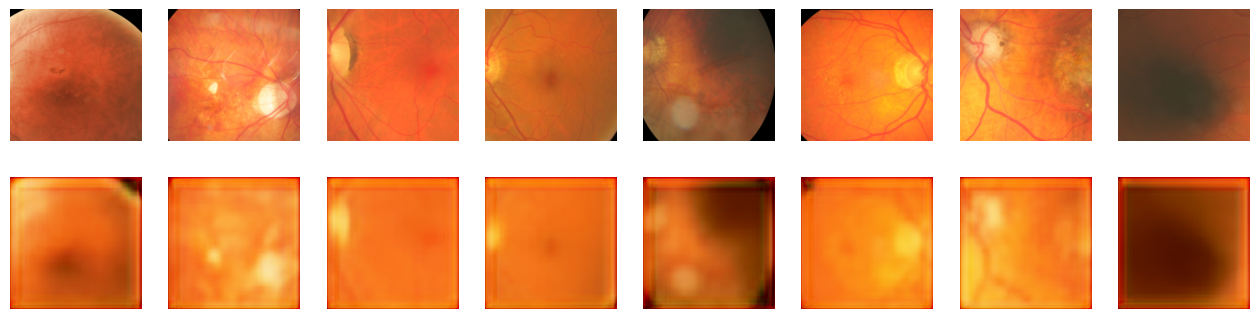

['Normal', 'Normal', 'Normal', 'Glaucoma', 'Normal', 'Glaucoma', 'Normal', 'Normal']


In [24]:
import torch
import matplotlib.pyplot as plt
from torchvision import models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the models
def load_model(model_path, model):
    model.load_state_dict(torch.load(model_path))
    model = model.to(device)
    model.eval()
    return model

# Initialize and load models
generator = Generator().to(device)
classifier_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
classifier_model.fc = nn.Linear(classifier_model.fc.in_features, 2)  # Binary classification

# Load trained models
classifier_model = load_model("/kaggle/working/best_glaucoma_resnet18_model.pth", classifier_model)
generator = load_model("/kaggle/input/v1/pytorch/default/1/glaucoma_generator_lambda_1.0.pth", generator)

# Define evaluation function using glaucoma images
def evaluate_generator(generator, classifier, dataloader, num_images=8):
    generator.eval()
    classifier.eval()
    label_map = {0: "Normal", 1: "Glaucoma"}
    
    with torch.no_grad():
        for images, _ in dataloader:
            images = images[:num_images].to(device)  # Limit to `num_images` images
            generated_images = generator(images)
            
            # Visualize real and generated images
            visualize_images(images, generated_images)
            
            # Classify generated images
            outputs = classifier(generated_images)
            _, predicted = torch.max(outputs, 1)
            predicted_labels = [label_map[pred.item()] for pred in predicted[:num_images]]  # Restrict to `num_images`
            print(predicted_labels)
            
            break  # Exit after the first batch

# Use the glaucoma_loader created during preprocessing
evaluate_generator(generator, classifier_model, glaucoma_loader)